In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/original" -d "/content/original"

In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ───────────────────────────────────────────────────────────────
# 1. 기본 경로 설정
# Colab 기준: '/content/' 폴더 아래에 original/ 폴더가 있다고 가정
base_dir       = '/content'
original_dir   = "/content/original/original"        # 원본 이미지가 클래스별로 들어있는 폴더
split_dir      = os.path.join(base_dir, 'split_data')        # train/val 폴더를 생성할 최상위 디렉토리
train_orig_dir = os.path.join(split_dir, 'train')            # split된 train 원본(70%) 디렉토리
val_orig_dir   = os.path.join(split_dir, 'val')              # split된 val 원본(30%) 디렉토리

aug_local_root = os.path.join(base_dir, 'augmentation3_local')
# → 최종 “원본 train(70%) + 오프라인 증강본(70% × 3)”을 저장할 폴더

# 증강 비율: 원본 1장당 k_per_image개 생성
k_per_image = 3

# ───────────────────────────────────────────────────────────────
# 2. split_data/train, split_data/val 폴더 생성하기 (원본을 70:30으로 나누기)
classes = sorted(os.listdir(original_dir))
# 참고: original/ 하위에 반드시 클래스별 폴더만 있고, 불필요한 파일이 없어야 합니다.

# (1) split_data, train, val 기본 디렉토리 생성
os.makedirs(train_orig_dir, exist_ok=True)
os.makedirs(val_orig_dir, exist_ok=True)

for cls in classes:
    src_cls_folder = os.path.join(original_dir, cls)
    if not os.path.isdir(src_cls_folder):
        continue  # 만약 이미지 파일이 아니라 딴 파일이 섞여 있으면 건너뛰기

    # 클래스별 train/val 디렉토리 경로
    train_cls_folder = os.path.join(train_orig_dir, cls)
    val_cls_folder   = os.path.join(val_orig_dir, cls)
    os.makedirs(train_cls_folder, exist_ok=True)
    os.makedirs(val_cls_folder, exist_ok=True)

    # (2) 클래스별로 파일 목록을 불러와서 shuffle 후 70:30 비율로 나누기
    all_files = [fname for fname in os.listdir(src_cls_folder)
                 if os.path.isfile(os.path.join(src_cls_folder, fname))]
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * 0.7)   # 70% → train
    # 나머지 30% → val
    train_files = all_files[:n_train]
    val_files   = all_files[n_train:]

    # (3) train_files를 split_data/train/[cls]/ 로 복사
    for fname in train_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(train_cls_folder, fname)
        shutil.copy(src_path, dst_path)

    # (4) val_files를 split_data/val/[cls]/ 로 복사
    for fname in val_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(val_cls_folder, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 3. 오프라인 증강을 위해 augmentation3_local 폴더 구조 만들기
#    그리고 train_orig_dir(70% 원본)을 여기에 복사(원본 train 70% 포함),
#    이후 ImageDataGenerator를 통해 증강본을 동일 폴더에 저장

# (1) augmentation3_local 및 클래스별 서브폴더 생성
os.makedirs(aug_local_root, exist_ok=True)
for cls in classes:
    cls_folder = os.path.join(aug_local_root, cls)
    os.makedirs(cls_folder, exist_ok=True)

# (2) 먼저 “원본 train(70%)”을 augmentation3_local/[cls]로 복사
for cls in classes:
    src_train_cls = os.path.join(train_orig_dir, cls)   # split_data/train/[cls]
    dst_aug_cls   = os.path.join(aug_local_root, cls)   # augmentation3_local/[cls]
    if not os.path.isdir(src_train_cls):
        continue
    for fname in os.listdir(src_train_cls):
        src_path = os.path.join(src_train_cls, fname)
        dst_path = os.path.join(dst_aug_cls, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 4. ImageDataGenerator 객체 정의 (오프라인 증강용)
datagen = ImageDataGenerator(
    rescale=1./255,        # 필요에 따라 스케일만 해 주거나(단 rescale은 옵션)
    rotation_range=20,     # 회전 범위
    width_shift_range=0.1, # 좌우 이동
    height_shift_range=0.1,# 상하 이동
    shear_range=0.1,       # 전단 변환
    zoom_range=0.1,        # 확대/축소
    horizontal_flip=True,  # 좌우 뒤집기
    fill_mode='nearest'    # 빈 공간을 가장 가까운 픽셀로 채우기
)

# ───────────────────────────────────────────────────────────────
# 5. 오프라인 증강 수행: train_orig_dir → augmentation3_local 에 k_per_image개씩 추가 생성

for cls in classes:
    # (1) flow_from_directory를 위해 ‘클래스 폴더만 읽어오는’ 폴더 설정
    #     ImageDataGenerator.flow_from_directory는 상위 폴더를 지정하고 classes 를 통해 특정 클래스만 읽을 수도 있지만,
    #     여기서는 train_orig_dir 아래에 이미 클래스별 폴더가 있으므로,
    #     gen = datagen.flow_from_directory(directory=train_orig_dir, classes=[cls], ...) 처럼 사용할 수 있습니다.

    src_for_aug = train_orig_dir        # split_data/train (클래스별 서브폴더 있음)
    dst_for_aug = os.path.join(aug_local_root, cls)

    # flow_from_directory로 해당 클래스를 하나씩 읽어들임
    gen = datagen.flow_from_directory(
        directory=src_for_aug,
        classes=[cls],
        target_size=(224, 224),  # 필요에 따라 원본 크기와 맞추거나 원하는 크기 지정
        batch_size=1,            # 1장씩 증강
        class_mode=None,         # 라벨을 따로 만들 필요 없음
        save_to_dir=dst_for_aug, # augmentation3_local/[cls]에 저장
        save_prefix=f'aug_{cls}',# 저장파일 접두사
        save_format='jpeg',      # 저장 포맷 (jpeg 혹은 png 등)
        shuffle=False            # 파일 순서대로 읽어가므로 shuffle=False
    )

    # (2) 총 원본 train 이미지 개수 * k_per_image만큼 증강본 생성
    #     gen.samples는 해당 클래스 train 이미지 개수(70% 원본)
    n_train_samples = gen.samples
    n_to_generate   = n_train_samples * k_per_image

    print(f'>>> 클래스 [{cls}]에 대해 원본 {n_train_samples}장 × {k_per_image} = {n_to_generate}장 증강을 생성합니다.')
    for i in range(n_to_generate):
        batch = next(gen)  # 내부적으로 이미지를 불러와서 증강하고, 지정된 폴더에 저장해 줌

print('>>> 오프라인 증강이 모두 완료되었습니다!')


Found 2327 images belonging to 1 classes.
>>> 클래스 [glioma]에 대해 원본 2327장 × 3 = 6981장 증강을 생성합니다.
Found 4692 images belonging to 1 classes.
>>> 클래스 [healthy]에 대해 원본 4692장 × 3 = 14076장 증강을 생성합니다.
Found 2286 images belonging to 1 classes.
>>> 클래스 [meningioma]에 대해 원본 2286장 × 3 = 6858장 증강을 생성합니다.
Found 2081 images belonging to 1 classes.
>>> 클래스 [pituitary]에 대해 원본 2081장 × 3 = 6243장 증강을 생성합니다.
>>> 오프라인 증강이 모두 완료되었습니다!


In [ ]:
import os
import shutil
import random

# 기존 val 폴더 경로
val_orig_dir = os.path.join(base_dir, 'split_data', 'val')

# 새로운 val/test 분할 폴더
val_final_dir  = os.path.join(base_dir, 'final_val')
test_final_dir = os.path.join(base_dir, 'final_test')

# 폴더 생성
os.makedirs(val_final_dir, exist_ok=True)
os.makedirs(test_final_dir, exist_ok=True)

for cls in classes:
    cls_val_src = os.path.join(val_orig_dir, cls)           # 기존 validation 폴더
    cls_val_dst = os.path.join(val_final_dir, cls)          # 새 validation 폴더
    cls_test_dst = os.path.join(test_final_dir, cls)        # 새 test 폴더

    os.makedirs(cls_val_dst, exist_ok=True)
    os.makedirs(cls_test_dst, exist_ok=True)

    if not os.path.isdir(cls_val_src):
        continue

    all_files = [f for f in os.listdir(cls_val_src)
                 if os.path.isfile(os.path.join(cls_val_src, f))]
    random.shuffle(all_files)

    n_half = len(all_files) // 2
    val_files  = all_files[:n_half]
    test_files = all_files[n_half:]

    for f in val_files:
        shutil.copy(os.path.join(cls_val_src, f), os.path.join(cls_val_dst, f))
    for f in test_files:
        shutil.copy(os.path.join(cls_val_src, f), os.path.join(cls_test_dst, f))

print("✅ split_data/val/ 폴더를 final_val(50%)과 final_test(50%)로 나누는 작업이 완료되었습니다.")


✅ split_data/val/ 폴더를 final_val(50%)과 final_test(50%)로 나누는 작업이 완료되었습니다.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------------------
# 1) 데이터 제너레이터(실시간 증강 + split)
# --------------------------------------------------------

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,   # 30%를 검증으로 떼어냄
    rotation_range=15,      # 증강 강도 ↑
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 3) train / validation / test 제너레이터 생성
# Assuming 'classes' variable contains the list of 4 class names
train_gen = data_gen.flow_from_directory(
    aug_local_root,
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    classes=classes # Specify the expected classes
)
# 검증용 generator
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_final_dir,
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    classes=classes
)

# 테스트용 generator
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_final_dir,
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,  # 예측값 정렬을 위해 반드시 False
    classes=classes
)

Found 45544 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.
Found 2442 images belonging to 4 classes.


In [ ]:
# 4) 콜백 설정 (Optional)
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,          # ← 조금 더 넉넉히
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,       # ← 2 → 4로 늘려서 “4번 epoch 연속 개선 없을 때만” lr 줄이기
    min_lr=1e-7,      # ← 학습률이 너무 작아져서 학습이 멈추는 것을 방지하기 위해 최저 lr 설정
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 127s 172ms/step - accuracy: 0.4802 - loss: 1.1906 - val_accuracy: 0.6190 - val_loss: 0.9615 - learning_rate: 1.0000e-04
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 192ms/step - accuracy: 0.6180 - loss: 0.9285 - val_accuracy: 0.5625 - val_loss: 1.1548 - learning_rate: 1.0000e-04
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 120s 169ms/step - accuracy: 0.6689 - loss: 0.8209 - val_accuracy: 0.6280 - val_loss: 0.9964 - learning_rate: 1.0000e-04
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 123s 172ms/step - accuracy: 0.7079 - loss: 0.7367 - val_accuracy: 0.5969 - val_loss: 1.1111 - learning_rate: 1.0000e-04
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 120s 169ms/step - accuracy: 0.7223 - loss: 0.6940 - val_accuracy: 0.6731 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 120s 169ms/step - accuracy: 0.7341 - loss: 0.6556 - val_accuracy: 0.6944 - val_loss: 0.8050 - learning_rate: 1.0000e-04
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 

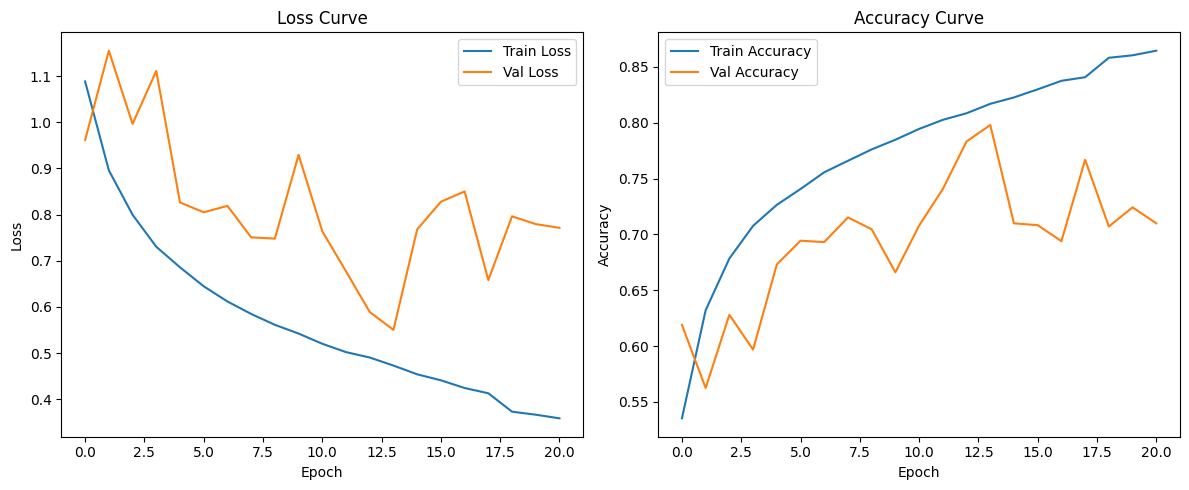

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 1) 모델 정의
model = Sequential()

# CNN block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# CNN 출력 형태: (32, 32, 64)
# → 이걸 시계열처럼 보기 위해 reshape (batch, timesteps, features)
model.add(Reshape((32, 32 * 64)))  # (batch_size, 32 time steps, 2048 features)

# LSTM
model.add(LSTM(128))

# FC Layer
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4-class 분류

# 2) 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) 학습
history_LSTM = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[earlystop, reduce_lr]
)

# 4) 학습 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step
✅ 테스트 정확도: 0.7858


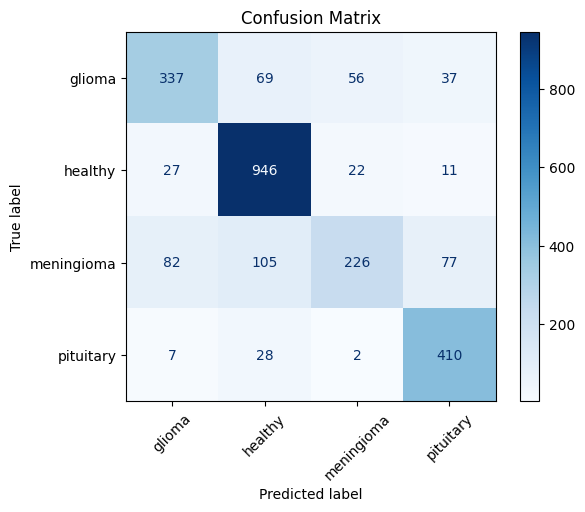


📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.68      0.71       499
     healthy       0.82      0.94      0.88      1006
  meningioma       0.74      0.46      0.57       490
   pituitary       0.77      0.92      0.84       447

    accuracy                           0.79      2442
   macro avg       0.77      0.75      0.75      2442
weighted avg       0.78      0.79      0.77      2442



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 예측 결과 얻기
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# 정확도 확인
test_acc = np.mean(pred_classes == true_classes)
print(f'✅ 테스트 정확도: {test_acc:.4f}')

# 혼동 행렬 출력
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-score 보고서
print("\n📊 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 188ms/step - accuracy: 0.4478 - loss: 1.2531 - val_accuracy: 0.5588 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 123s 173ms/step - accuracy: 0.5233 - loss: 1.1374 - val_accuracy: 0.6063 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 121s 169ms/step - accuracy: 0.5554 - loss: 1.0511 - val_accuracy: 0.6538 - val_loss: 0.8608 - learning_rate: 0.0010
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 120s 168ms/step - accuracy: 0.5937 - loss: 0.9623 - val_accuracy: 0.6911 - val_loss: 0.7763 - learning_rate: 0.0010
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 145s 173ms/step - accuracy: 0.6345 - loss: 0.8972 - val_accuracy: 0.7231 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 118s 166ms/step - accuracy: 0.6709 - loss: 0.8170 - val_accuracy: 0.7575 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 120s 168ms/step - accura

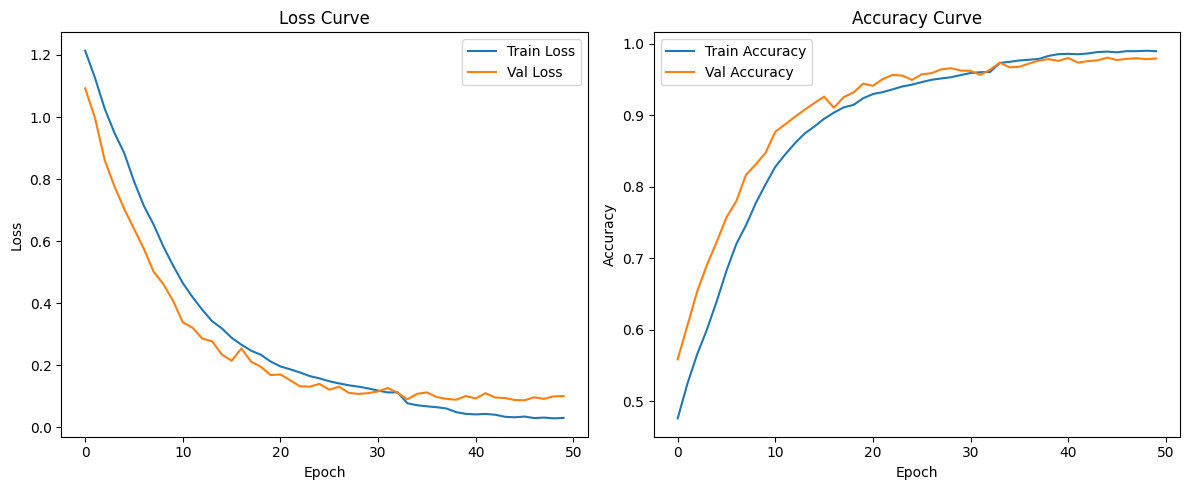

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# 하이퍼파라미터 설정

batch_size = 64
epochs = 50
learning_rate = 0.001
input_size = 128            # 한 타임스텝(feature 수, 이미지 가로 픽셀)
sequence_length = 128       # 시퀀스 길이(이미지 세로 픽셀)
hidden_size = 256
num_layers = 3
num_classes = 4

# LSTM 모델 구성

model_LSTM = models.Sequential()

# 입력 형태: (batch, 128, 128, 1)
# LSTM에 입력하기 위해 이미지 차원을 (batch, seq_len, input_size)로 변환해야 함
model_LSTM.add(layers.Reshape((sequence_length, input_size), input_shape=(sequence_length, input_size, 1)))

# LSTM 계층 쌓기 (return_sequences=True는 num_layers-1번째까지, 마지막은 False)
for i in range(num_layers):
    return_seq = (i < num_layers - 1)
    model_LSTM.add(layers.LSTM(hidden_size, return_sequences=return_seq))

# 출력층 (클래스 개수만큼)
model_LSTM.add(layers.Dense(num_classes, activation='softmax'))

# 모델 컴파일
model_LSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 학습

history_LSTM = model_LSTM.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[earlystop, reduce_lr]
)


# 학습 결과 시각화

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
✅ 테스트 정확도: 0.9738


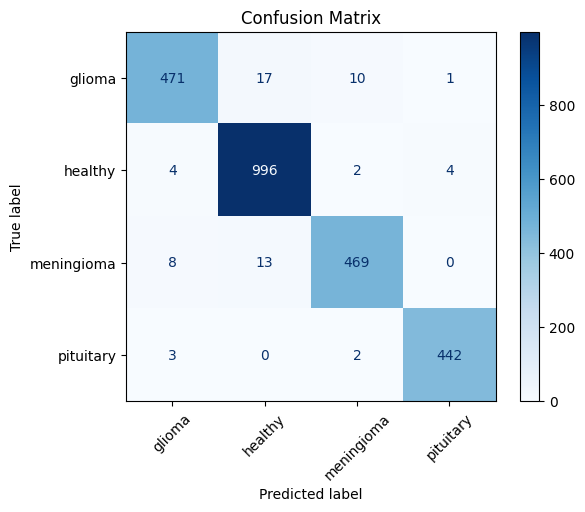


📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.94      0.96       499
     healthy       0.97      0.99      0.98      1006
  meningioma       0.97      0.96      0.96       490
   pituitary       0.99      0.99      0.99       447

    accuracy                           0.97      2442
   macro avg       0.97      0.97      0.97      2442
weighted avg       0.97      0.97      0.97      2442



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 예측 결과 얻기
pred_probs = model_LSTM.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# 정확도 확인
test_acc = np.mean(pred_classes == true_classes)
print(f'✅ 테스트 정확도: {test_acc:.4f}')

# 혼동 행렬 출력
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-score 보고서
print("\n📊 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))